# Training our first book genre classification model 

Now that we have done some initial exploration of the annotated dataset we'll turn to the process of creating our first model. Since we are taking a pragmatic approach we want to try and get stuck into our problem fairly quickly. Often we learn a lot about our task and data by trying to train a model. This can make it useful to try and train a model fairly early on to sense check our approach. For example, if we are collecting new training data, it makes sense to try and train a model as soon as we have some data to check if:

- our model is able to learn anything from the data
- our annoations are in a format we can use
- there is anything we need to consider when collecting further annotations. 

This notebook covers the process of training a text classifier to predict whether a book title refers to a 'fiction' or 'non-fiction' book based on the annotation data discussed previously. 

In this notebook we focus on a fairly basic overview of how to approach this topic. The following chapters/notebooks will build on this introduction to cover some other more niche topics and approaches.

## fastai 

For this notebook we will use the `fastai` deep learning library {cite:ps}`howardFastaiLayeredAPI2020` for training our model. We won't provide a full introduction to the library but will try and explain what we're doing as we're going along. The `fastai` library offers a 'layered API' which includes a high level API that we can use to quickly develop our model. This will allow us to focus on quick development of our model and developing our overall approach as opposed to writing a lot of code. 

We start by installing the fastai library 

In [ ]:
!pip install fastai==2.5.2

Now we've installed fastai we can import it. The version used for this notebook is shown for reference. 

In [ ]:
import fastai

fastai.__version__

'2.5.2'

We are going to be working with text so we import the text module from the fastai library. 

Since we are going to be working with CSVs and doing some tidying of data we also import pandas. 

In [ ]:
from fastai.text.all import *
import pandas as pd

## Why are you not using BERT?

```{image} https://www.codemotion.com/magazine/wp-content/uploads/2020/05/bert-google-1200x675.png
:alt: angry picture of Bert
:class: bg-primary mb-1
:width: 400px
:align: right
```

If you have had much exposure to developments in NLP or deep learning you will likely have heard of BERT or other Transformer based models. BERT is an approach to training language models first outlined in *BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding* {cite:p}`devlin2019bert`.

Transformer based Language models have demonstrated strong performance across a range of tasks. We may still want to entertain using other approaches to NLP. This includes our old friend the LSTM. 

There are a few reasons we choose to start with a slightly less trendy model:

- it allow us to focus on the broad process of using transfer learning to start with 
- it allows for more focus on the 'data part' of the process of creating a machine learning model. This is less exciting to many people but arguably in a GLAM setting should be a major/main focus. 

For those we want a Transformer based approached a later notebook does do this...

### Exploring our data

We'll briefly take a look at our data, starting by loading it. We specify *some* of the Pandas datatypes. We make sure `BL record ID` is loaded as a string so it doesn't chop of leading zeros i.e. `00001` isn't turned into `1`. We also use the `category` type for values which might be duplicated a bit since this will save a bit of memory. 

In [ ]:
csv_data_url = (
    "https://bl.iro.bl.uk/downloads/36c7cd20-c8a7-4495-acbe-469b9132c6b1?locale=en"
)

In [ ]:
dtypes = {
    "BL record ID": "string",
    "Type of resource": "category",
    "Name": "category",
    "Type of name": "category",
    "Country of publication": "category",
    "Place of publication": "category",
    "Genre": "category",
    "Dewey classification": "string",
    "BL record ID for physical resource": "string",
    "annotator_main_language": "category",
    "annotator_summaries_language": "string",
}

In [ ]:
df = pd.read_csv(csv_data_url, low_memory=False, dtype=dtypes)

Let's take a quick peek at what the data looks like: 

In [ ]:
df.head(1)

,BL record ID,Type of resource,Name,Dates associated with name,Type of name,Role,All names,Title,Variant titles,Series title,Number within series,Country of publication,Place of publication,Publisher,Date of publication,Edition,Physical description,Dewey classification,BL shelfmark,Topics,Genre,Languages,Notes,BL record ID for physical resource,classification_id,user_id,created_at,subject_ids,annotator_date_pub,annotator_normalised_date_pub,annotator_edition_statement,annotator_genre,annotator_FAST_genre_terms,annotator_FAST_subject_terms,annotator_comments,annotator_main_language,annotator_other_languages_summaries,annotator_summaries_language,annotator_translation,annotator_original_language,annotator_publisher,annotator_place_pub,annotator_country,annotator_title,Link to digitised book,annotated
0,014602826,Monograph,"Yearsley, Ann",1753-1806,person,NaN,"More, Hannah, 1745-1833 [person] ; Yearsley, Ann, 1753-1806 [person]",Poems on several occasions [With a prefatory letter by Hannah More.],NaN,NaN,NaN,England,London,NaN,1786,Fourth edition MANUSCRIPT note,NaN,<NA>,Digital Store 11644.d.32,NaN,NaN,English,NaN,003996603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


We can also see what columns we have in our data. 

In [ ]:
df.columns

Index(['BL record ID', 'Type of resource', 'Name',
       'Dates associated with name', 'Type of name', 'Role', 'All names',
       'Title', 'Variant titles', 'Series title', 'Number within series',
       'Country of publication', 'Place of publication', 'Publisher',
       'Date of publication', 'Edition', 'Physical description',
       'Dewey classification', 'BL shelfmark', 'Topics', 'Genre', 'Languages',
       'Notes', 'BL record ID for physical resource', 'classification_id',
       'user_id', 'created_at', 'subject_ids', 'annotator_date_pub',
       'annotator_normalised_date_pub', 'annotator_edition_statement',
       'annotator_genre', 'annotator_FAST_genre_terms',
       'annotator_FAST_subject_terms', 'annotator_comments',
       'annotator_main_language', 'annotator_other_languages_summaries',
       'annotator_summaries_language', 'annotator_translation',
       'annotator_original_language', 'annotator_publisher',
       'annotator_place_pub', 'annotator_country', 'annot

We can see a field `annotated` this indicates whether the columns has been annotated. Since we want only annotated data to start with lets filter on this. 

In [ ]:
df = df[df["annotated"] == True]

Let's also look at a few of the columns to look at what kind of text is stored there. We're likely to use the title as input for our genre classification model

### Genre labels 
Since we're going to try and detect genre lets take a quick look at what are labels look like. 


In [ ]:
df.annotator_genre.value_counts()

Non-fiction                                       2847
Fiction                                           1527
The book contains both Fiction and Non-Fiction      18
Can't tell                                           6
Name: annotator_genre, dtype: int64

We have a few classes of genre that we'll drop for now. We can do this the lazy way by dropping any valyes for genre which don't appear at least a hundred times. 

In [ ]:
df = df[df.groupby("annotator_genre")["annotator_genre"].transform("count").ge(100)]

We can now get a sense of the distribution of our labels

In [ ]:
df["annotator_genre"].value_counts(normalize=True)

Non-fiction    0.650892
Fiction        0.349108
Name: annotator_genre, dtype: float64

We can see our data isn't balanced. We have many more examples of non-fiction compared to fiction. 

## Train, validation and test splits 

For a supervised learning tasks like the one we're doing here we need to make sure we have a validation set. This allows us to check that our model is learning general properties that help with a particular task rather than memorizing the training data. Creating a validation dataset is one way of doing this. 

We could split our data in a variety of different ways. The first, and often satisfactory approach is to randomly split the data. We take 30% of our data for validation and use the rest for training. 

> Depending on the nature of your data, choosing a validation set can be the most important step {cite}`thomasHowWhyCreate`

One reason random spits might not always work is that we can introduce data leakage across validation and training data. A common example of this is time series data. If the task involves predicting a future event you want to make sure you split your data by a time point. In this example we could split on a number of different things in the data; the language of the text, the date of publication, the place of publication etc. 


### Data leakage 💦

As we have seen data leakage occurs when a model 'sees' data it shouldn't. In our case there are various things we want to watch out for as a form of data leakage. We can try and be very 'clever' about idenfiying potential soruces of data leakage but one of the main things we want to watch out for is that we don't duplicate a piece of data in training and validation sets. Since our model is supposed to predict from titles let's see if any of these appear more than once. 

In [ ]:
df["Title"].value_counts().value_counts()

1     789
3     351
5     346
4     135
2     111
15      1
10      1
9       1
6       1
Name: Title, dtype: int64

We can see here that most of the titles only appear one time. This is probably what we'd expect but if we know a bit about this data, or 19th century publishing practices, digitiation processes etc we might have been suspicous to this possibility of titles appearing multiple times. For example the British Library probably has more than [one copy of Oliver Twist](http://explore.bl.uk/primo_library/libweb/action/search.do?cs=frb&ct=frb&frbg=436868648&fctN=facet_frbrgroupid&fctV=436868648&doc=BLL01016286578&lastPag=&lastPagIndx=1&rfnGrp=frbr&frbrSrt=rank&frbrRecordsSource=Primo+Local&frbrJtitleDisplay=&frbrIssnDisplay=&frbrEissnDisplay=&frbrSourceidDisplay=BLL01&rfnGrpCounter=1&query=any%2Ccontains%2Coliver%20twist&fn=search&indx=1&search_scope=LSCOP-ALL&dscnt=0&vl(2084770704UI0)=any&scp.scps=scope%3A(BLCONTENT)&fctV=books&vid=BLVU1&institution=BL&ct=facet&rfnGrp=1&tab=local_tab&fctN=facet_rtype&fromDL=&vl(freeText0)=oliver%20twist&dstmp=1627396213982). Although many of these editions will have slightly different titles some will overlap. 

If we don't take this into account and randomly split out data into training and validation sets our model might get to 'cheat' since 'Oliver Twist' might appear as an example in the training data, and in the validation data. If our model has already 'seen' that 'Oliver Twist' is fiction we might be less sure that it has 'learned' anything more general about genre. Instead it may have memorized some of the examples. If this is the case our model might perform better on the validation data then it would otherwise. This might in turn mean we have disappointing results when we apply our model to new unseen data. 

### GroupShuffleSplit 

How can we split our data into training and validation data taking into account this potential leakage of titles between our training and validation data? Helpfully the [sci-kit learn](scikit-learn.org/) library has support for various types of data splitting. In this case we'll use `GroupShuffleSplit` which allows us to specify a groups to split on. This means members of those groups won't appear both in both splits. We can use this to make sure non of the titles 'leak' across our training and validation data. 

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

In [ ]:
train_inds, valid_ins = next(
    GroupShuffleSplit(n_splits=2, test_size=0.25).split(df, groups=df["Title"])
)

In [ ]:
df_train, df_valid = df.iloc[train_inds].copy(), df.iloc[valid_ins].copy()

In [ ]:
len(df_train), len(df_valid)

(3297, 1077)

In [ ]:
df_train.annotator_genre.value_counts()

Non-fiction    2149
Fiction        1148
Name: annotator_genre, dtype: int64

In [ ]:
df_valid.annotator_genre.value_counts(normalize=True)

Non-fiction    0.648097
Fiction        0.351903
Name: annotator_genre, dtype: float64

We can check if any of our titles still overlap

In [ ]:
import numpy as np

np.intersect1d(df_train.Title.to_numpy(), df_valid.Title.to_numpy())

array([], dtype=object)

As we can see we now have no titles that appear in both out training and validation data. We can shove our datafames into a new DataFrame and use a `is_valid` column to indicate which part of the data it belongs too. 

In [ ]:
df_train["is_valid"] = False
df_valid["is_valid"] = True

In [ ]:
df = pd.concat([df_train, df_valid])

In [ ]:
df.annotator_genre.value_counts(normalize=True)

Non-fiction    0.650892
Fiction        0.349108
Name: annotator_genre, dtype: float64

We'll save this for later use as a csv file. 

In [ ]:
df.to_csv("train_valid.csv", index=False)

## What about our test data?

You might be wondering why we didn't also create any test data. As part of the process of creating these notebooks/doing this genre prediction work, we created some new test data. This was generated by randomly sampling from the BL books metadata. This was done so we could be sure that the distribution of our test data matched the data we would be running our model against. 

We will work with this test data in the subsequent notebook/chapter and dig into some of the issues around test data in more detail there. Now we have our data ready we'll move to the training part of the process.

# One simple trick: the ✨magic✨ of transfer learning 

Arguably one of the most important developments in deep learning over the past decade has been the adoption of transfer learning. Transfer learning has allowed for deep learning approaches to be deployed to much smaller datasets with a reduced compute requirement. This opens up the potential of developing and applying deep learning to a much broader range of tasks. 

## What is transfer learning?

Transfer learning is the process by which we apply a model which has been trained on one task on a new task. The intuition is that the model will have a 'head start' on the new task compared to starting from scratch. Often the pre-training task has much more data than we might have available. We can still take advantage of this by fine-tuning our model on our specific task. As an example we might have a model trained to predict the sentiment of movie reviews. We could potentially fine-tune this model on a smaller dataset of book reviews with sentiment labels. Although there will be differences in the language used, we would probably find a model trained on sentiment analysis on movies will still do better than starting from scratch with a new model. 

In our example we will utilize a particular type of pre-trained model as the starting point; a language model. 

## 🔧 Fine tuning a language model on book titles 🔧

A language model can be used as a starting point for many tasks. Language models are models which, in broad terms, learn the probabilities of word occurrence. There are various ways in which language models can be trained but increasingly they are trained in an unsupervised manner i.e. they are trained from unlabeled data. A example of a task a language model be given is to predict the next work in a sentence for example:

the cat sat on the ____ 

As a model gets better at performing this task it develops a representation of language which can be useful for other downstream tasks. 

For our starting point we will follow the 'ULMFIT' (Universal Language Model Fine Tuning) approach.

```{image} figs/ulmfit.png
:alt: aIllustration of the ulmfit approach
:width: 500px
:align: left
```

As we can see from the illustration we'll start with a language model which has been trained on a general language modeling task, in this case on English Wikipedia articles. We'll then 'fine-tune' this model on all of our title data (our target domain). Through this process our language model should get better at 'understanding' what the book titles in our corpus looks like. In a later stage we will then use our fine tuned language model to create a classifier. 

We can use all of our data for language modeling so we create a new DataFrame which contains all of the metadata: 

In [ ]:
df_lang = pd.read_csv(csv_data_url, low_memory=False, dtype=dtypes)

We can take a look at what is included in this dataset:

In [ ]:
df_lang.head(1)

,BL record ID,Type of resource,Name,Dates associated with name,Type of name,Role,All names,Title,Variant titles,Series title,Number within series,Country of publication,Place of publication,Publisher,Date of publication,Edition,Physical description,Dewey classification,BL shelfmark,Topics,Genre,Languages,Notes,BL record ID for physical resource,classification_id,user_id,created_at,subject_ids,annotator_date_pub,annotator_normalised_date_pub,annotator_edition_statement,annotator_genre,annotator_FAST_genre_terms,annotator_FAST_subject_terms,annotator_comments,annotator_main_language,annotator_other_languages_summaries,annotator_summaries_language,annotator_translation,annotator_original_language,annotator_publisher,annotator_place_pub,annotator_country,annotator_title,Link to digitised book,annotated
0,014602826,Monograph,"Yearsley, Ann",1753-1806,person,NaN,"More, Hannah, 1745-1833 [person] ; Yearsley, Ann, 1753-1806 [person]",Poems on several occasions [With a prefatory letter by Hannah More.],NaN,NaN,NaN,England,London,NaN,1786,Fourth edition MANUSCRIPT note,NaN,<NA>,Digital Store 11644.d.32,NaN,NaN,English,NaN,003996603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


look at a few example titles

In [ ]:
df_lang["Title"][:4]

0                                                                     Poems on several occasions [With a prefatory letter by Hannah More.]
1                     A Satyr against Vertue. (A poem: supposed to be spoken by a Town-Hector [By John Oldham. The preface signed: T. A.])
2    The Aeronaut, a poem; founded almost entirely, upon a statement, printed in the newspapers, of a voyage from Dublin, in October, 1812
3                                                                                          The Prince Albert, a poem [By Joseph Plimsoll.]
Name: Title, dtype: object

Since we only care about the `Title` column we'll take a subset of the DataFrame with only the `Title`. We include `BL Record ID` to keep our data as a DataFrame rather than a pandas Series. We do this because fastai is expecting a DataFrame for loading our data. 

In [ ]:
df_lang = df_lang[["Title", "BL record ID"]].copy(deep=True)

# Loading data into fastai 

We can now load our data into fastai. Note you might need to drop the batch size if you get a CUDA memory error. 

We create a dataloaders for language model data. This uses the full metadata for all the books we will eventually classify. Since we can train these in an unsupervised way we can make use of all of the data here. We can create forward and backwards language models. The backwards language model will do the same as the forwards language model but instead of predicting the next word, in a sentence it will be trained to predict the previous one. In this example we'll just train the forward language model but we can often get good results by combining a forward and backwards model.  

In [ ]:
bs = 256

In [ ]:
data_lm = TextDataLoaders.from_df(
    df_lang, text_col="Title", valid_pct=0.2, bs=bs, is_lm=True
)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


We can take a look at our data using the `show_batch` method. We can see that the second column `text_` is the same as the first column except the words are shifted along. 

In [ ]:
data_lm.show_batch()

,text,text_
0,"xxbos a xxmaj guide to xxmaj hampstead . xxmaj new and revised edition , etc xxbos xxmaj xxunk politicos ou historia dos xxunk xxunk politicos da provincia do xxmaj pará desde o anno de 1821 xxunk ' 1835 … xxmaj xxunk parte xxbos xxmaj hills and xxmaj plains : a very old story xxbos xxmaj histoire du comté de xxmaj dunois , de ses comtes et de sa capitale . xxmaj par","a xxmaj guide to xxmaj hampstead . xxmaj new and revised edition , etc xxbos xxmaj xxunk politicos ou historia dos xxunk xxunk politicos da provincia do xxmaj pará desde o anno de 1821 xxunk ' 1835 … xxmaj xxunk parte xxbos xxmaj hills and xxmaj plains : a very old story xxbos xxmaj histoire du comté de xxmaj dunois , de ses comtes et de sa capitale . xxmaj par xxup"
1,"the xxunk highwayman . xxmaj by the author of ' dick xxmaj clinton , ' ' ned xxmaj scarlet , ' etc xxbos xxmaj the xxmaj xxunk of the xxmaj shield ; or , the xxmaj adventures of xxmaj grenville xxmaj le xxmaj marchant during the franco - prussian xxmaj war … xxmaj with illustrations , etc xxbos xxmaj yorkshire in xxmaj olden xxmaj times . xxmaj edited by xxup w. xxmaj","xxunk highwayman . xxmaj by the author of ' dick xxmaj clinton , ' ' ned xxmaj scarlet , ' etc xxbos xxmaj the xxmaj xxunk of the xxmaj shield ; or , the xxmaj adventures of xxmaj grenville xxmaj le xxmaj marchant during the franco - prussian xxmaj war … xxmaj with illustrations , etc xxbos xxmaj yorkshire in xxmaj olden xxmaj times . xxmaj edited by xxup w. xxmaj andrews"
2,"xxunk . ' xxbos xxmaj prisoners of the xxmaj tower of xxmaj london . xxmaj being an account of some who at divers times lay captive within its walls … xxmaj with … illustrations xxbos xxmaj aegypten . xxmaj forschungen über xxmaj land und xxmaj volk während eines xxunk xxmaj aufenthalts , etc xxbos xxunk сборникъ , издаваемый xxunk xxunk xxunk xxunk подъ редакціею … а . с . xxunk . том",". ' xxbos xxmaj prisoners of the xxmaj tower of xxmaj london . xxmaj being an account of some who at divers times lay captive within its walls … xxmaj with … illustrations xxbos xxmaj aegypten . xxmaj forschungen über xxmaj land und xxmaj volk während eines xxunk xxmaj aufenthalts , etc xxbos xxunk сборникъ , издаваемый xxunk xxunk xxunk xxunk подъ редакціею … а . с . xxunk . том 1"
3,"] xxbos xxmaj life 's xxmaj xxunk and other poems xxbos xxmaj notes on the xxmaj geology of the xxmaj hull , xxmaj barnsley , & xxmaj west xxmaj riding xxmaj junction xxmaj railway and xxmaj dock xxbos xxmaj the xxmaj castle of xxmaj vincigliata [ with illustrations . ] xxbos xxmaj the xxmaj wives revenged ; a comic opera , in one act , etc [ based on ' les xxmaj","xxbos xxmaj life 's xxmaj xxunk and other poems xxbos xxmaj notes on the xxmaj geology of the xxmaj hull , xxmaj barnsley , & xxmaj west xxmaj riding xxmaj junction xxmaj railway and xxmaj dock xxbos xxmaj the xxmaj castle of xxmaj vincigliata [ with illustrations . ] xxbos xxmaj the xxmaj wives revenged ; a comic opera , in one act , etc [ based on ' les xxmaj femmes"
4,"] xxbos xxmaj xxunk . a poem xxbos xxmaj history of xxmaj xxunk , xxmaj xxunk , and xxmaj south xxmaj xxunk , xxmaj maine , from their first exploration , xxup a.d . 1605 ; with family genealogies , etc xxbos xxmaj ulysses , or scenes and studies in many lands xxbos xxmaj history of xxmaj scott xxmaj county , xxmaj iowa . xxmaj with … biographies of representative citizens .","xxbos xxmaj xxunk . a poem xxbos xxmaj history of xxmaj xxunk , xxmaj xxunk , and xxmaj south xxmaj xxunk , xxmaj maine , from their first exploration , xxup a.d . 1605 ; with family genealogies , etc xxbos xxmaj ulysses , or scenes and studies in many lands xxbos xxmaj history of xxmaj scott xxmaj county , xxmaj iowa . xxmaj with … biographies of representative citizens . xxmaj"
5,"tragedy of xxmaj ida xxmaj noble , etc [ a novel . ] xxbos xxmaj clark 's xxmaj guide and xxmaj history of xxmaj rye , to which is added its political history , interspersed with many pleasing & inte

Now we have our data ready we create a `language_model_learner` this is a convenience function to quickly get a model setup for a language model task. To use this we need to pass in our data, the type of model we want to use and optionally some metric(s) to track. We will use `to_fp16()` to train our model using [mixed precission](https://docs.nvidia.com/deeplearning/performance/mixed-precision-training/index.html). This allows us to use less memory and train our model a little bit faster. This can be useful if you are working with limited GPU resources. 

In [ ]:
lm_learn_fwd = language_model_learner(data_lm, AWD_LSTM, metrics=Perplexity()).to_fp16()

We are now ready to fit our model. Initially we fit the model for 5 epochs. We use a fastai callback to save our best performing model (using the lowest perplexity as our measure of 'best'). 

In [ ]:
lm_learn_fwd.fit_one_cycle(
    5, cbs=[SaveModelCallback(monitor="perplexity", comp=np.less)]
)

epoch,train_loss,valid_loss,perplexity,time
0,5.053834,4.514159,91.300728,01:08
1,4.627872,3.961763,52.549911,01:08
2,4.280094,3.714055,41.019817,01:08
3,4.084582,3.631602,37.773266,01:07
4,3.997313,3.619023,37.301094,01:07


Better model found at epoch 0 with perplexity value: 91.30072784423828.
Better model found at epoch 1 with perplexity value: 52.54991149902344.
Better model found at epoch 2 with perplexity value: 41.01981735229492.
Better model found at epoch 3 with perplexity value: 37.77326583862305.
Better model found at epoch 4 with perplexity value: 37.30109405517578.


One of the suggestions made in the ULMFIT paper is to 'gradually' train the layers of our model. We can unfreeze all the layers and use another handy fastai method `lr_find` to get a sense of what a sensible learning rate might be. 

SuggestedLRs(valley=0.0002290867705596611)

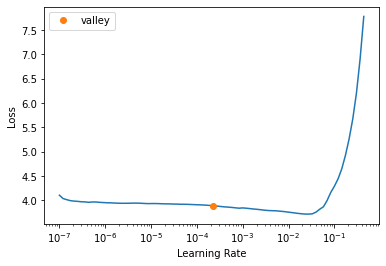

In [ ]:
lm_learn_fwd.unfreeze()
lm_learn_fwd.lr_find()

We can pass a slice at the learning rate. This will use something called a 'discriminative' learning rate. This means that the lower layers of our model will have a lower learning rate, and the later layers will have a higher learning rate. The intution here is that the lower layers might contain more 'general' features which we don't want to update as agressively whilst the later layers are more task specific. 

Again we train for 5 epochs and save our best performing model. 

In [ ]:
lm_learn_fwd.fit_one_cycle(
    5,
    lr_max=slice(5e-5, 1e-4),
    cbs=[SaveModelCallback(monitor="perplexity", comp=np.less)],
)

epoch,train_loss,valid_loss,perplexity,time
0,3.879096,3.449919,31.497826,01:13
1,3.715576,3.324599,27.787848,01:13
2,3.587684,3.270434,26.322758,01:13
3,3.543618,3.250468,25.802412,01:13
4,3.493116,3.246511,25.700520,01:13


Better model found at epoch 0 with perplexity value: 31.497825622558594.
Better model found at epoch 1 with perplexity value: 27.7878475189209.
Better model found at epoch 2 with perplexity value: 26.322757720947266.
Better model found at epoch 3 with perplexity value: 25.802412033081055.
Better model found at epoch 4 with perplexity value: 25.700519561767578.


We could spend longer on this process but for now we'll save our 'encoder'. This 'encoder' will be used in our classification model (we'll get to this shortly). 

In [ ]:
lm_learn_fwd.save_encoder("ft_enc")

## Look at language model predictions 

To get a sense of whether our Language Model has 'learned' anything useful we can ask it to make some predictions based on a prompt. We'll create small function for doing this. 


In [ ]:
def lm_preds(text_promt, N_WORDS=10, N_SENTENCES=3):
    preds = [
        lm_learn_fwd.predict(text_promt, N_WORDS, temperature=0.75)
        for _ in range(N_SENTENCES)
    ]
    print("\n".join(preds))

In [ ]:
lm_preds("A history")

a history of France = a Union of the
a history of the Isle of Wight The
a history of the County of Iowa , with historical


In [ ]:
lm_preds("Poems")

Poems The Castle Fire , and other
Poems on Greece and Greece The
Poems of Narrative Soul Heart in


In [ ]:
lm_preds("verhaal")

verhaal miss Jane Austen : a novel
verhaal katie della Physique de la Terre
verhaal i Wake Up a Journey to


In [ ]:
lm_preds("wiskunde")

xxunk , a History of the Northern Irish
xxunk 's Molly Fly and other poems
xxunk on Eve Park in Wales


In [ ]:
lm_preds("Gedicht")

Xxunk Park . In the United States
Xxunk in the East : a poem The
Xxunk 's Guide to India Visitors to


In [ ]:
lm_preds("An analysis")

An analysis of the French Revolution from the French
An analysis of the Halifax County District Court
An analysis of the Gulf , and the Gulf of


In [ ]:
lm_preds("Living with Machines")

Living with Machines in Palestine . By W. Gordon
Living with Machines : Life and Life in France ,
Living with Machines : a history of London … and other stories


In [ ]:
lm_preds("The Haunted")

The Haunted House , a sketch of the home of
The Haunted House in Paris , France , from
The Haunted House , a Catholic Catholic church in


In [ ]:
lm_preds("London")

London Road : a novel The Present
London : a novel The Secret of
London 's Gold Coast The Flash


We can see that these aren't completely weird predictions for titles (they aren't all completely sensible either). It should be noted that the model we're using here isn't intended primarily as a text generation model like [GPT3](https://en.wikipedia.org/wiki/GPT-3) so we shouldn't evaluate it too much on it's ability to generate sensible sounding text. We can now move on to training our classifier. 

## Training our classifier

So far we have now done the following steps;

- downloaded a pretrained language model (trained on Wikipedia) 
- we have fine-tuned this model on our data i.e. the model has learned more about the language used in (mostly 19th Century) book titles

We can now use this fine-tuned language model to train a text classification model that will take as input the title of a book and predict 'non-fiction' or 'fiction' as a label. 

We first need to create a dataloader for our classifications data. This will look very similar to our previous model. 

Again, we take a subset of our data that we need. This makes loading the data a bit faster. 

In [ ]:
df = df[["Title", "annotator_genre", "is_valid"]]

In [ ]:
data_class = TextDataLoaders.from_df(
    df,  # the dataframe we're using as input
    text_col="Title",  # text column
    label_col="annotator_genre",  # label column
    valid_col="is_valid",  # the column used to indicate valid/training data
    text_vocab=data_lm.vocab,  # the vocab from our langauge model
    bs=bs,  # batch size
)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


You can see above that we use the same vocab as our language model. We do this to ensure that our classification vocab matches our language model vocab and its associated encoder.

We can take a look at our data. 

In [ ]:
data_class.show_batch()

,text,category
0,"xxbos a xxmaj relation of a xxmaj voyage to xxmaj sagadahoc , now first printed from the original manuscript in the xxmaj lambeth xxmaj palace xxmaj library [ entitled : ' the xxmaj relation of a xxmaj voyage unto xxmaj new xxmaj england began from the xxmaj lizard ye first of xxmaj june 1607 . xxmaj by xxmaj captn . xxmaj popham in ye ship ye xxmaj gift . xxmaj captn . xxmaj gilbert in ye xxmaj mary and xxmaj john , ' etc . ] xxmaj edited with preface , notes and appendix by … xxup b. xxup f. xxmaj decosta [ with a paper annexed , entitled : ' the xxmaj two xxmaj hundred and seventy - third xxmaj anniversary of xxmaj sagadahoc . ' ]",Non-fiction
1,"xxbos a xxmaj relation of a xxmaj voyage to xxmaj sagadahoc , now first printed from the original manuscript in the xxmaj lambeth xxmaj palace xxmaj library [ entitled : ' the xxmaj relation of a xxmaj voyage unto xxmaj new xxmaj england began from the xxmaj lizard ye first of xxmaj june 1607 . xxmaj by xxmaj captn . xxmaj popham in ye ship ye xxmaj gift . xxmaj captn . xxmaj gilbert in ye xxmaj mary and xxmaj john , ' etc . ] xxmaj edited with preface , notes and appendix by … xxup b. xxup f. xxmaj decosta [ with a paper annexed , entitled : ' the xxmaj two xxmaj hundred and seventy - third xxmaj anniversary of xxmaj sagadahoc . ' ]",Non-fiction
2,"xxbos a xxmaj relation of a xxmaj voyage to xxmaj sagadahoc , now first printed from the original manuscript in the xxmaj lambeth xxmaj palace xxmaj library [ entitled : ' the xxmaj relation of a xxmaj voyage unto xxmaj new xxmaj england began from the xxmaj lizard ye first of xxmaj june 1607 . xxmaj by xxmaj captn . xxmaj popham in ye ship ye xxmaj gift . xxmaj captn . xxmaj gilbert in ye xxmaj mary and xxmaj john , ' etc . ] xxmaj edited with preface , notes and appendix by … xxup b. xxup f. xxmaj decosta [ with a paper annexed , entitled : ' the xxmaj two xxmaj hundred and seventy - third xxmaj anniversary of xxmaj sagadahoc . ' ]",Non-fiction
3,"xxbos a xxmaj tour through xxmaj italy , exhibiting a view of its xxmaj scenery , its xxmaj antiquities , and its xxmaj monuments ; particularly as they are objects of xxmaj classical xxmaj interest … with an account of the present state of its cities and towns and occasional observations on the recent spoliations of the xxmaj french . 3 vol . ( vol . xxrep 3 i . a xxmaj classical xxmaj tour through xxmaj italy and xxmaj sicily ; tending to illustrate some districts which have not been described by xxmaj mr . xxmaj eustace in his classical tour . xxmaj by xxmaj sir xxup r. xxmaj colt xxmaj hoare . )",Non-fiction
4,"xxbos a xxmaj tour through xxmaj italy , exhibiting a view of its xxmaj scenery , its xxmaj antiquities , and its xxmaj monuments ; particularly as they are objects of xxmaj classical xxmaj interest … with an account of the present state of its cities and towns and occasional observations on the recent spoliations of the xxmaj french . 3 vol . ( vol . xxrep 3 i . a xxmaj classical xxmaj tour through xxmaj italy and xxmaj sicily ; tending to illustrate some districts which have not been described by xxmaj mr . xxmaj eustace in his classical tour . xxmaj by xxmaj sir xxup r. xxmaj colt xxmaj hoare . )",Non-fiction
5,"xxbos a xxmaj tour through xxmaj italy , exhibiting a view of its xxmaj scenery , its xxmaj antiquities , and its xxmaj monuments ; particularly as they are objects of xxmaj classical xxmaj interest … with an account of the present state of its cities and towns and occasional observations on the recent spoliations of the xxmaj french . 3 vol . ( vol . xxrep 3 i . a xxmaj classical xxmaj tour through xxmaj italy and xxmaj sicily ; tending to illustrate some districts which have not been described by xxmaj mr . xxmaj eustace in his classical tour . xxmaj by xxmaj sir xxup r. xxmaj colt xxmaj hoare . )",Non-fiction
6,"xxbos a xxmaj tour through xxmaj italy , exhibiting a view of its xxmaj scenery , its xxmaj antiquities , and its xxmaj monuments ; particu

## xxbos, xxmaj ??? 

You'll see above that our text includes `xxmaj`, `xxup` and other tokens we might not recognize. These are special tokens used by fastai to encode some information about the text. For example:

> TK_MAJ (xxmaj) is used to indicate the next word begins with a capital in the original text
> TK_UP (xxup) is used to indicate the next word is written in all caps in the original text

We can add our own rules if we want. This might be useful for example if you are working with metadata or text which contains some kind of structured information. 

We'll now create our classifier model. This is very similar to what we did before except we pass in two metrics this time and make sure to pass in the classification data. 

In [ ]:
learn_class = text_classifier_learner(
    data_class, AWD_LSTM, metrics=[accuracy, F1Score(average="macro")]
).to_fp16()

Now we have a learner created we load the encoder we trained on our language data previously. This means our model will start from these weights. 

In [ ]:
learn_class.load_encoder("ft_enc")

We can again use `lr_find` to suggest a learning rate.

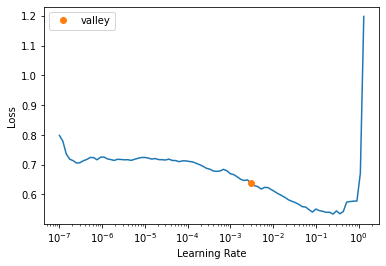

In [ ]:
suggested_lr = learn_class.lr_find()

## YOLO training


This time we will use the learning rate suggested by the `valley` method for suggesting a learning rate (there are [others](https://www.novetta.com/2021/03/learning-rate/) we could use).

We also train for much longer (100 epochs). We use a callback to keep track of best model (using the f1 score) and use another callback to stop when when we haven't seen any improvement in some time. This helps automate the process a little bit for us. 

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.665443,0.668866,0.525534,0.517140,00:02
1,0.606742,0.612578,0.602600,0.600962,00:03
2,0.569475,0.480823,0.791086,0.786726,00:03
3,0.537582,0.379936,0.857939,0.850516,00:02
4,0.511371,0.349232,0.873723,0.866713,00:03
5,0.487751,0.297151,0.900650,0.892650,00:03
6,0.461770,0.276135,0.909935,0.901799,00:03
7,0.440010,0.282361,0.896936,0.890024,00:03
8,0.421166,0.257838,0.914578,0.906915,00:03
9,0.403049,0.266430,0.900650,0.891030,00:03


Better model found at epoch 0 with f1_score value: 0.5171399367413458.


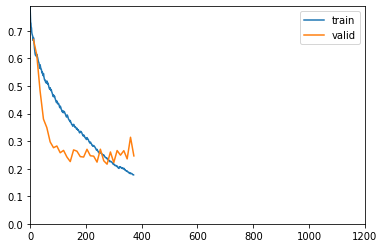

Better model found at epoch 1 with f1_score value: 0.6009619380038229.
Better model found at epoch 2 with f1_score value: 0.7867257283625517.
Better model found at epoch 3 with f1_score value: 0.8505155901731697.
Better model found at epoch 4 with f1_score value: 0.8667127725403123.
Better model found at epoch 5 with f1_score value: 0.8926504411300307.
Better model found at epoch 6 with f1_score value: 0.9017990673313098.
Better model found at epoch 8 with f1_score value: 0.9069151334776335.
Better model found at epoch 10 with f1_score value: 0.907948717948718.
Better model found at epoch 11 with f1_score value: 0.9195073434721286.
No improvement since epoch 11: early stopping


In [ ]:
learn_class.fit_one_cycle(
    100,
    lr_max=float(suggested_lr.valley),
    cbs=[
        ShowGraphCallback(),
        SaveModelCallback(monitor="f1_score"),
        EarlyStoppingCallback(monitor="f1_score", patience=20),
    ],
)

We can save our model progress along the way. This means if we mess up later and make the model worse we can go back to an early version. 

In [ ]:
learn_class.save("stage-1")

Path('models/stage-1.pth')

In [ ]:
learn_class.load("stage-1")

Again we can 'unfreeze' the model to train all layers of the model. We'll use `lr_find` to suggest a learning rate for when our model is unfrozen. 

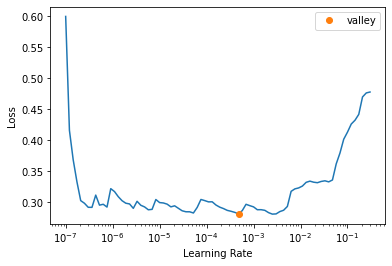

In [ ]:
learn_class.unfreeze()
suggested_lr = learn_class.lr_find()

Again we use a slightly YOLO approach to training and train for 40 epochs. We do make sure to save our best model and stop early if we don't improve. 

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.295892,0.232815,0.922006,0.914085,00:03
1,0.294546,0.238351,0.913649,0.905402,00:03
2,0.289235,0.229033,0.920149,0.912149,00:03
3,0.283422,0.228210,0.920149,0.912149,00:03
4,0.283902,0.223157,0.916435,0.907718,00:03
5,0.279701,0.234657,0.919220,0.911398,00:03
6,0.273055,0.229389,0.923863,0.916338,00:03
7,0.264773,0.230474,0.918292,0.910216,00:03
8,0.258779,0.220282,0.919220,0.911182,00:03
9,0.250745,0.222746,0.922934,0.915265,00:03


Better model found at epoch 0 with f1_score value: 0.91408547008547.


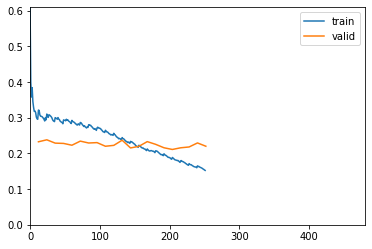

Epoch 4: reducing lr to 2.4287370138544e-05
Better model found at epoch 6 with f1_score value: 0.916337627889352.
Epoch 10: reducing lr to 4.775283508704886e-05
Better model found at epoch 11 with f1_score value: 0.9178043083556245.
Epoch 15: reducing lr to 4.341455859128301e-05
Epoch 19: reducing lr to 3.607777952852039e-05
No improvement since epoch 11: early stopping


In [ ]:
learn_class.fit_one_cycle(
    40,
    lr_max=slice(float(suggested_lr.valley)),
    cbs=[
        ShowGraphCallback(),
        SaveModelCallback(monitor="f1_score"),
        ReduceLROnPlateau(patience=4, monitor="f1_score"),
        EarlyStoppingCallback(monitor="f1_score", patience=10),
    ],
)

In [ ]:
learn_class.save("stage-2")

Path('models/stage-2.pth')

### Look at our results 

We'll now look at our results. We can use `get_preds` to return predictions. If we don't pass anything to this method it will use the validation data. We store predictions in `y_pred`, we also get back our labels which we'll store in `y_true`

In [ ]:
_, y_pred, y_true = learn_class.get_preds(with_decoded=True)

We can use these predictions to get various metrics, for example using the metrics from scikit-learn. 

In [ ]:
from sklearn.metrics import f1_score, classification_report, accuracy_score

In [ ]:
f1_score(y_pred, y_true)

0.94176851186197

```{note}
You will probably notice that this score is different from the score we got in our training. This is because we use a different variant of f1 score.
```

#### How are we doing by label?

Often we want to know our performance by label. We can use `classification report` to give us a breakdown. This can be very helpful because the overall metric can hide poor performance on a particular label. 

In [ ]:
print(classification_report(y_true, y_pred, target_names=learn_class.dls.vocab[1]))

              precision    recall  f1-score   support

     Fiction       0.90      0.89      0.89       384
 Non-fiction       0.94      0.95      0.94       693

    accuracy                           0.92      1077
   macro avg       0.92      0.92      0.92      1077
weighted avg       0.92      0.92      0.92      1077



## Testing on new data 😬

We may be quite confident in our predictions based on the above score but it's often a good idea to be skeptical and about your performance metrics on the data we have for training. 

### Data drift 😅

One potential challenge facing us when we want to apply machine learning to a particular collection is data drift. Data drift occurs when distribution of our training data differs from the distribution of the data we are predicting against. Or put in simpler terms the data we predict against doesn't quite look the same as the data our model was trained on. This shift could be subtle or it could be quite drastic. In our particular case we could think about a number of things being particularly important differences. 

#### Language 

From the discussion of generating the training data as part of the Zooniverse crowdsourcing task we know that there was a choice available to participants about the language the annotated. This means we can't necessarily assume that the languages which appear in our training data will be distributed in the same way as in the data we predict on. If our model has mainly seen English, French and Dutch, examples in the training data it might do better on those languages. The model may even do okay on German examples because of some language similarities to Dutch, but we would probably not expect it to do well on Russian book titles. We might be happy to only have predictions work well for some languages but we need to be aware of the potential limitations for the model on other languages. 

#### Time period

The time period covered by our data is both large, and skewed. This means if we randomly sample from the full dataset we will have less examples of book titles from earlier periods. This might mean our model performs less well on book titles from earlier periods. There are various ways we could try and deal with this, and how we try and deal with this possible issue depends on *what* we are trying to achieve. In the Living with Machines case, we mainly care about 19th Century books so if the model sucks at 16th Century book titles we probably don't mind. If we want to use this model to update all catalogue records we definitely need to keep this in mind. 

#### Hard examples

This is a bit of a meta one but essentially we might want to worry a little bit about whether some book titles are hard to classify as fiction or non-fiction (for our human annotators). Most annotation tools/tasks allow annotators to skip a task if they are unsure. This might result in our training data missing many 'hard' examples. Our model in turn will therefore be trained on 'easier' titles and not on 'harder' examples. When the model is making predictions it may do worse on these 'hard' examples. 

To help alleviate our anxiety we'll quickly check our performance on some test data which was randomly sampled from our metadata. We'll discuss this more in the next chapter/notebook. For now we'll load this data in a CSV and use this to test our model. 

In [ ]:
# TODO update with final version of data
df_test = pd.read_csv("test_errors.csv")

We'll grab the columns we want

In [ ]:
df_test = df_test[["title", "true_label"]]

We get rid of any rows where we don't have an annotation

In [ ]:
df_test = df_test.dropna(subset=["true_label"]).copy()

In [ ]:
df_test = df_test[df_test.true_label.isin({"non_fiction", "fiction"})]

In [ ]:
test_data = learn_class.dls.test_dl(df_test.loc[:, "title"])

In [ ]:
preds = learn_class.get_preds(dl=test_data)

In [ ]:
probs = preds[0]

In [ ]:
predictions = probs.argmax(1)

In [ ]:
true_labels = df_test.true_label.astype("category").cat.codes

We now print out a classification report showing the result on our test data

In [ ]:
print(
    classification_report(
        true_labels,
        predictions,
        target_names=learn_class.dls.vocab[1],
    )
)

              precision    recall  f1-score   support

     Fiction       0.83      0.94      0.88       296
 Non-fiction       0.97      0.90      0.93       554

    accuracy                           0.91       850
   macro avg       0.90      0.92      0.91       850
weighted avg       0.92      0.91      0.91       850



In [ ]:
df_test["model_preds"] = preds[0].argmax(1)

In [ ]:
df_test["model_preds"]

0      1
1      1
2      0
3      1
4      1
      ..
994    0
995    0
996    0
997    0
998    1
Name: model_preds, Length: 850, dtype: int64

In [ ]:
learn_class.dls.vocab[1]

['Fiction', 'Non-fiction']

We want to explore how our model is working, and where systematic mistakes might be happening. To get ready for doing this we'll prepare a CSV which contains both our model predictions and the corrected label. We'll use this in a later notebook. 

In [ ]:
df_test["model_preds"] = df_test["model_preds"].replace(
    {0: "fiction", 1: "non_fiction"}
)

In [ ]:
df_test.to_csv("model-1-test-preds.csv", index=False)

In [ ]:
df_test

,title,true_label,model_preds
0,"['The Memorial History of the City of New York from its first settlement to the year, 1892. Edited by J. G. Wilson. [With illustrations.]']",non_fiction,non_fiction
1,"['Историческая Хрестоматія по Русской исторіи ... Составлена Я. Г. Гуревичемъ и Б. А. Павловичемъ ... Изданіе второе ... дополненное Я. Гуревичемъ. Часть 1, 2']",non_fiction,non_fiction
2,['Colville of the Guards'],fiction,fiction
3,['A treatise on Inflammation. [With plates.]'],non_fiction,non_fiction
4,['Borys: ustęp z dziejów dwunastego wieku. (Odbitka z “Przewodnika naukowego i literackiego.”)'],non_fiction,non_fiction
...,...,...,...
994,"[""Sidney Cooper's Comic Pantomime, Dick Whittington and his Cat. Christmas, 1886-7""]",fiction,fiction
995,['Helga: a poem in seven Cantos. [With notes and an appendix.]'],fiction,fiction
996,['The Geological Observer'],non_fiction,fiction
997,['Lays of Far Cathay and others. A collection of original poems. By “Tung Chia.” Illustrations by H. H'],fiction,fiction


## Saving model 

We can save our model and it's associated data loading steps easily using the fastai `export` method. This will allow us to re-use this model later if we want or to share it with others. 

In [ ]:
learn_class.export("20210928-model.pkl")

## Conclusion and next steps

In the next section we will look into our model results in some more detail and see what we can do to improve our results further. 

:::{note}
The main things we tried to show in this notebook:
- the process of creating a deep learning model for predicting if a book title is 'fiction' or 'non-fiction'. 
- the importance of creating good validation data when developing models. 
- the potential for our models performance to be lower on new unseen data and why a test set can help identify this potential risk.
:::